<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 - AutoEncoder
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [1]:
# Set your student number
student_number = 98109837
Name = 'Amirreza'
Last_Name = 'Soleimanbeigi'

# Rules
- You **are** allowed to add or remove cells.
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [2]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q3.ipynb")
with open(f'python_code_Q3_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# Autoencoders (25 Points Extra)

<font size=4>
Author: Ahmad Salimi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

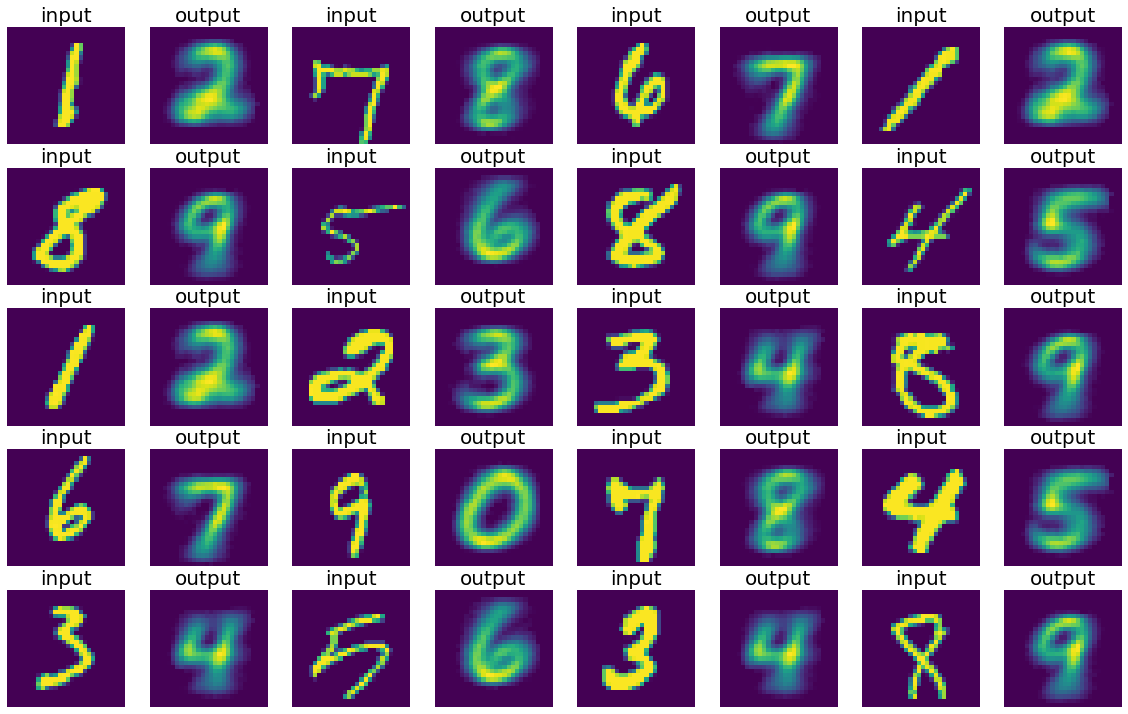

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [2]:
from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
#### IMPLEMENT YOUR MODEL ####
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(  # B 1 28 28
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), # B 16 28 28
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # B 32 28 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2), # B 64 15 15
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2), # B 128 9 9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), # B 128 4 4
            nn.BatchNorm2d(128)
        )
        self.decoder = nn.Sequential(    # B 128 4 4
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1), # B 64 4 4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), # B 32 4 4
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2), # B 16 9 9
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=3, output_padding=1), # B 1 28 28
            nn.ReLU()
        )


    def forward(self, input):
        output = self.encoder(input)
        output = self.decoder(output)
        return output

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [19]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [20]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=256,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [21]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
model = AutoEncoder().to(device)
loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [23]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
epoch_nums = 10
best_val_loss = float('inf')


for epoch in range(epoch_nums):
    train_loss, val_loss = 0, 0

    model.train()
    for input_digits, next_digits, labels in train_dataloader:
        input_digits, next_digits = torch.unsqueeze(input_digits, 1), torch.unsqueeze(next_digits, 1)
        input_digits, next_digits = input_digits.to(device), next_digits.to(device)
        outputs = model(input_digits)
        batch_loss = loss_fn(outputs, next_digits)
        train_loss += batch_loss * len(labels)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()


    model.eval()
    for input_digits, next_digits, labels in val_dataloader:
        with torch.no_grad():
            input_digits, next_digits = torch.unsqueeze(input_digits, 1), torch.unsqueeze(next_digits, 1)
            input_digits, next_digits = input_digits.to(device), next_digits.to(device)
            outputs = model(input_digits)

            batch_loss = loss_fn(outputs, next_digits)
            val_loss += batch_loss * len(labels)


    train_loss /= len(train_dataloader.dataset)
    val_loss /= len(val_dataloader.dataset)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        state_dict = model.state_dict()

    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

[Epoch 0]	Train Loss: 0.0642	Validation Loss: 0.0581
[Epoch 1]	Train Loss: 0.0561	Validation Loss: 0.0556
[Epoch 2]	Train Loss: 0.0553	Validation Loss: 0.0553
[Epoch 3]	Train Loss: 0.0550	Validation Loss: 0.0553
[Epoch 4]	Train Loss: 0.0547	Validation Loss: 0.0554
[Epoch 5]	Train Loss: 0.0545	Validation Loss: 0.0553
[Epoch 6]	Train Loss: 0.0543	Validation Loss: 0.0551
[Epoch 7]	Train Loss: 0.0542	Validation Loss: 0.0552
[Epoch 8]	Train Loss: 0.0540	Validation Loss: 0.0552
[Epoch 9]	Train Loss: 0.0538	Validation Loss: 0.0554


## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [24]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
model.load_state_dict(state_dict)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspo

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

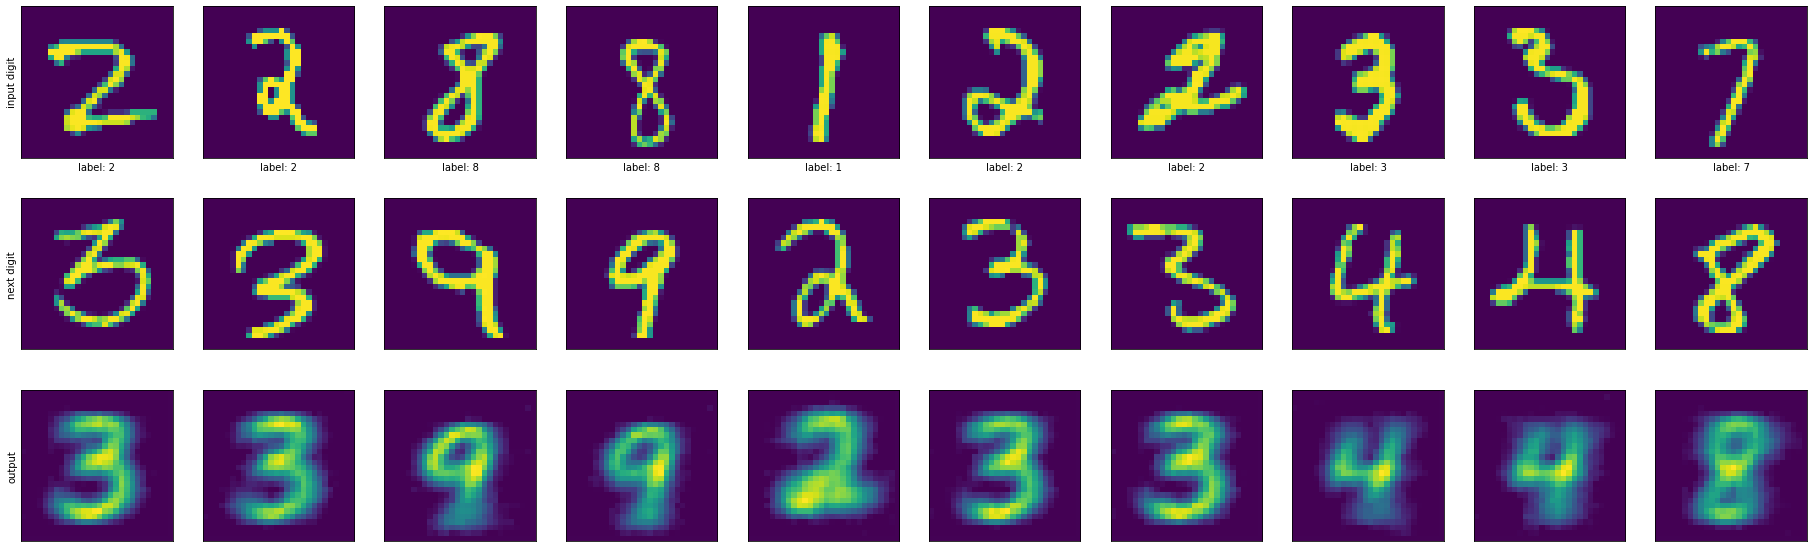

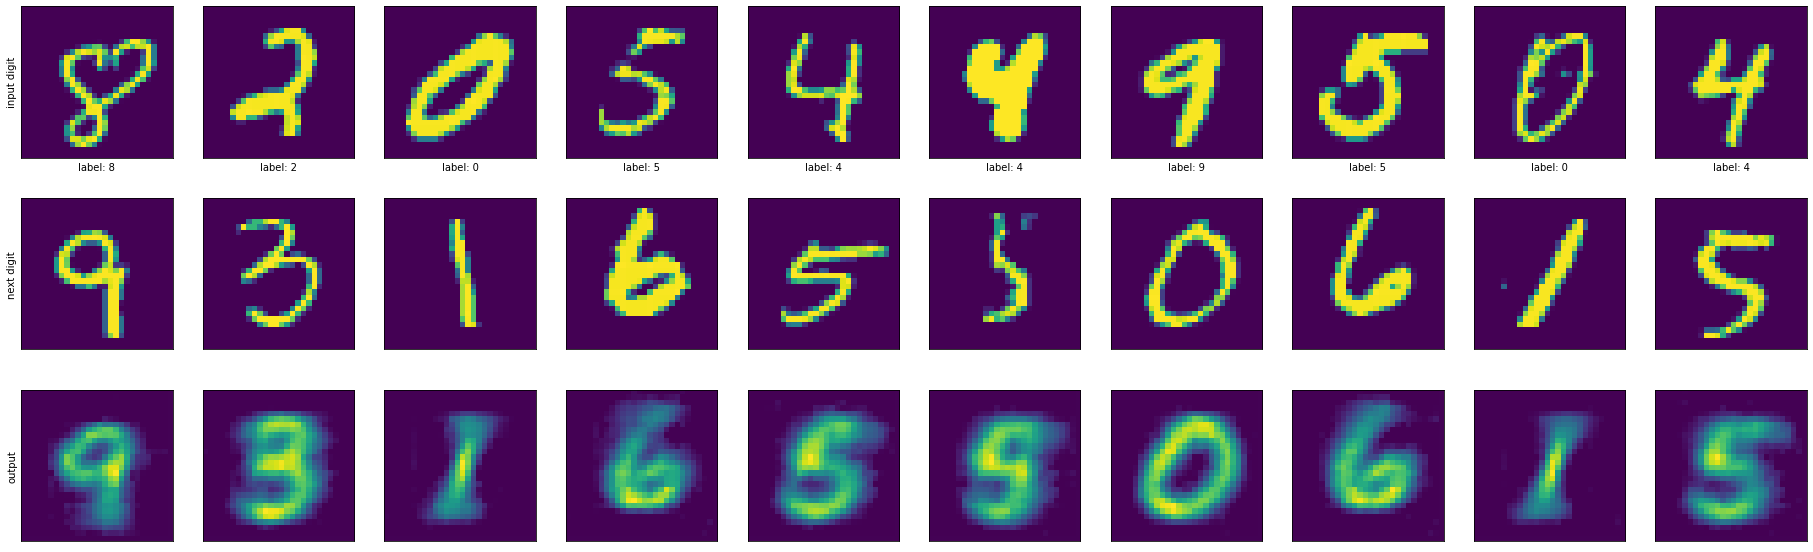

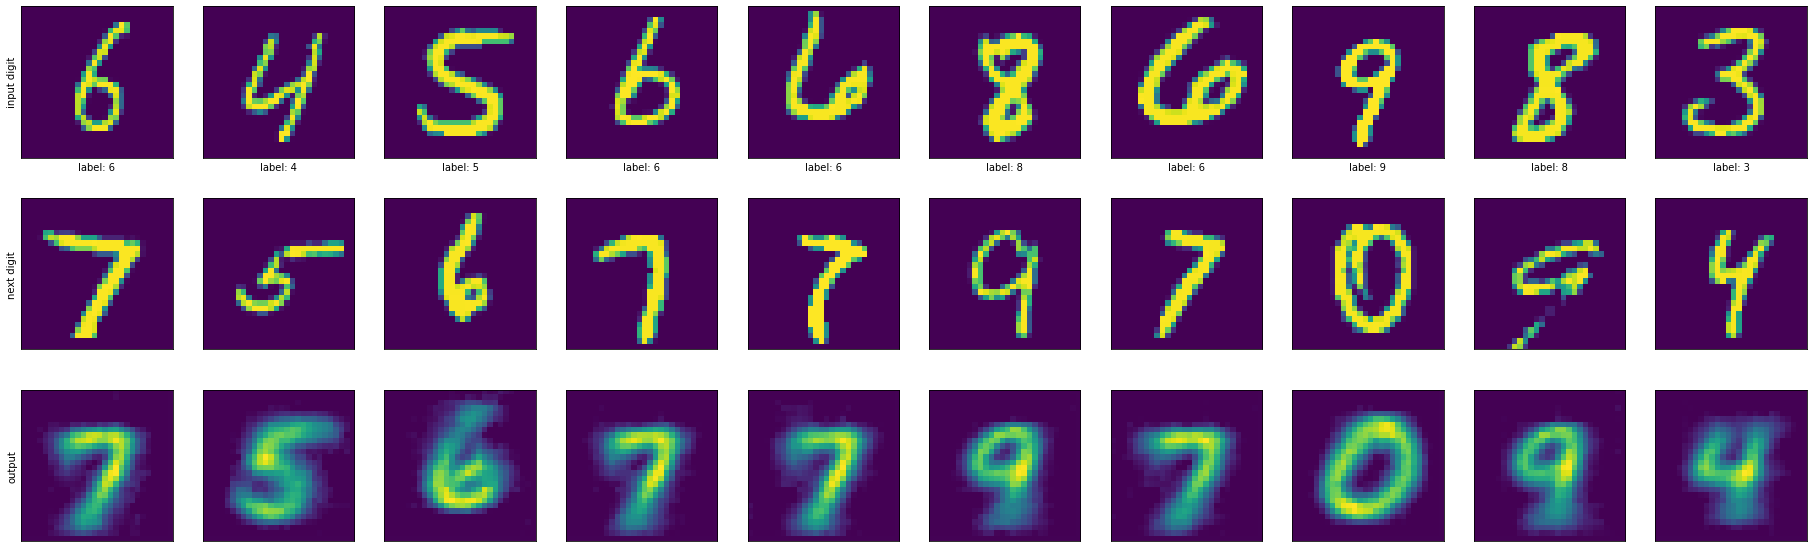

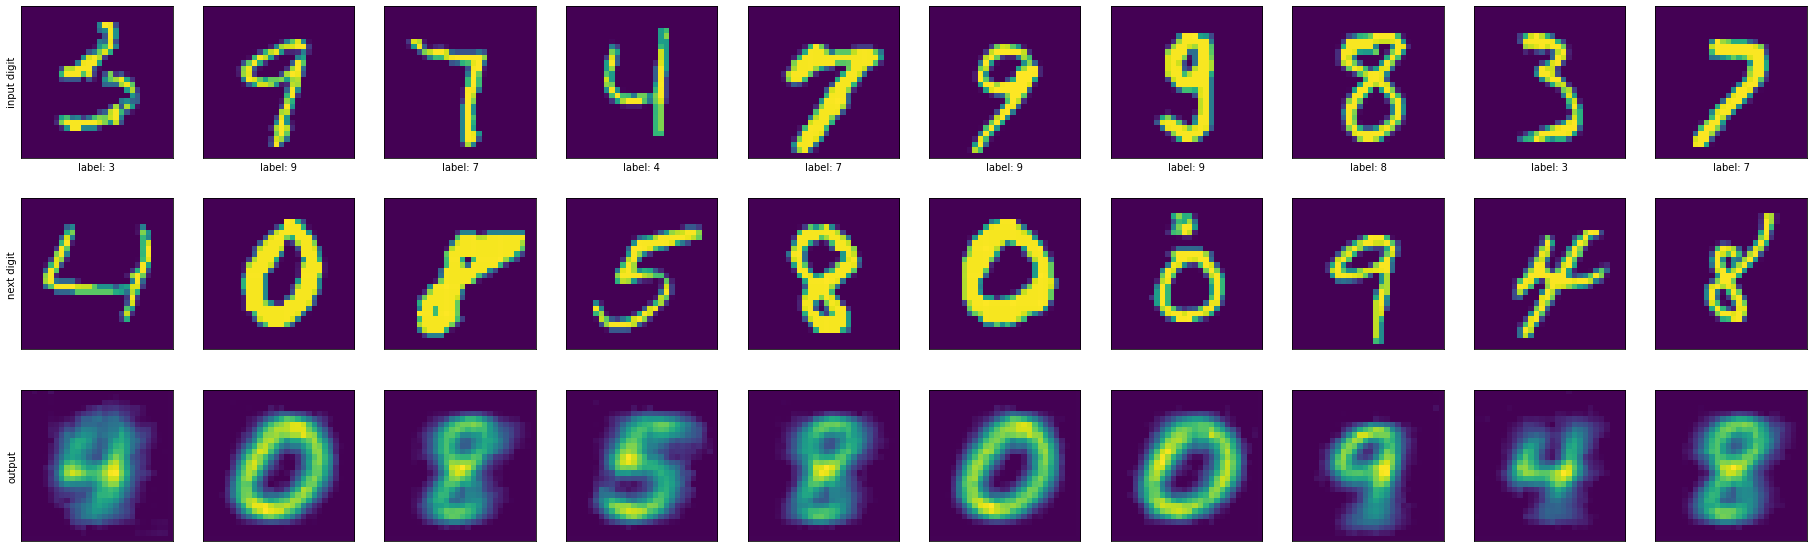

In [36]:
#### VISUALIZE YOUR MODEL ####
test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=10,
    shuffle=False
)

def plot(input_digits, next_digits, labels, outputs):
    num_imgs = 10
    fig, axs = plt.subplots(3, num_imgs, figsize=(32, 10))
    for i in range(num_imgs):
        axs[0, i].imshow(input_digits[i, 0].cpu())
        axs[1, i].imshow(next_digits[i, 0])
        axs[2, i].imshow(outputs[i, 0].cpu())
        axs[0, i].set_xlabel(f"label: {labels[i]}");
        for k in range(3):
            axs[k, i].set_yticks([])
            axs[k, i].set_xticks([])

    axs[0, 0].set_ylabel("input digit")
    axs[1, 0].set_ylabel("next digit")
    axs[2, 0].set_ylabel("output")
    plt.show()

for i, (input_digits, next_digits, labels) in enumerate(train_dataloader):
    if i == 4:
        break
    with torch.no_grad():
        input_digits, next_digits = torch.unsqueeze(input_digits, 1), torch.unsqueeze(next_digits, 1)
        input_digits = input_digits.to(device)
        outputs = model(input_digits)
        plot(input_digits, next_digits, labels, outputs)
